In [1]:
!pip install transformers datasets imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,f1_score,confusion_matrix,accuracy_score

from transformers import AutoTokenizer,BertForSequenceClassification,Trainer,TrainingArguments,BertTokenizer
from datasets import Dataset
import torch
# model =yiyanghkust/finbert-tone


In [3]:
data =pd.read_csv("all-data.csv",encoding ="ISO-8859-1",names=["label","text"])

In [4]:
data.head()

,label,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [5]:
data.shape

(4846, 2)

In [6]:
data.isna().sum()

,0
label,0
text,0


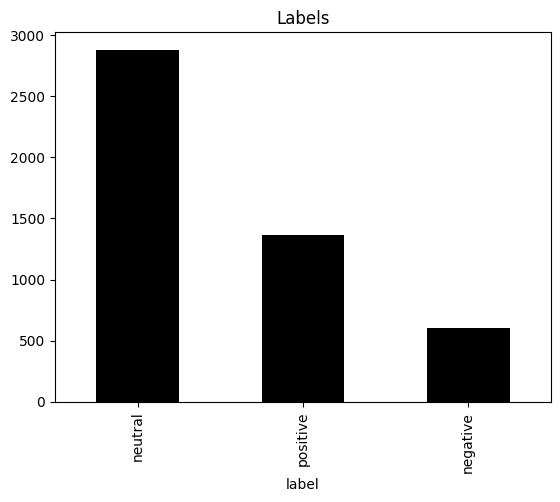

In [7]:
data["label"].value_counts().plot(kind="bar",color="black")
plt.title("Labels")
plt.show()

In [8]:
data["label"].value_counts()

,count
label,
neutral,2879
positive,1363
negative,604


In [9]:
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("wordnet")

sw = set(stopwords.words("english"))
wn = WordNetLemmatizer()

def pre_processing(text):
  text = text.translate(str.maketrans("","",string.punctuation))
  text = text.lower().split()
  text = " ".join(wn.lemmatize(word) for word in text if word not in sw)
  return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [10]:
data["text"] = data["text"].apply(pre_processing)
data.head()

,label,text
0,neutral,according gran company plan move production ru...
1,neutral,technopolis plan develop stage area less 10000...
2,negative,international electronic industry company elco...
3,positive,new production plant company would increase ca...
4,positive,according company updated strategy year 200920...


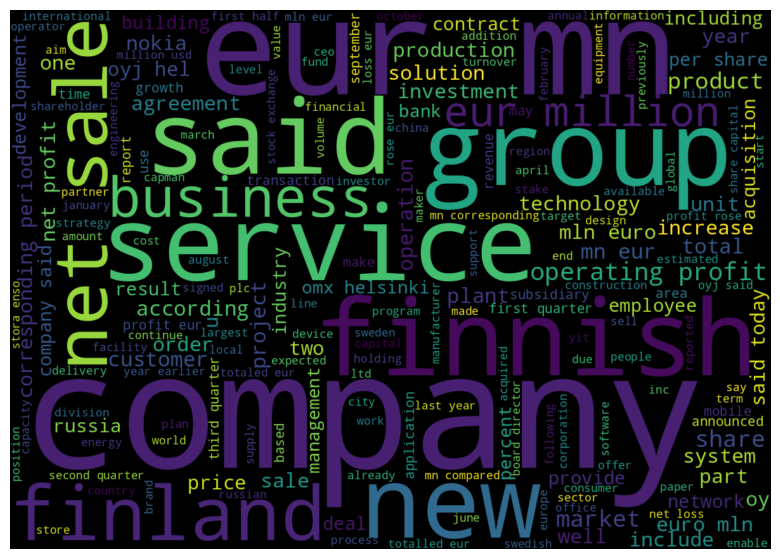

In [11]:
from wordcloud import WordCloud
t = " ".join (word for word in data["text"])
wc = WordCloud(width=1200,height=850,background_color="black",random_state=42).generate(t)
plt.figure(figsize=(10,7))
plt.imshow(wc,interpolation="bilinear")
plt.axis("off")
plt.show()

In [12]:
#since data is unbalbnced we use random over sampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy="auto",random_state=42)
x=data.iloc[:,1:2]
y=data["label"]
x_resampled,y_resampled=ros.fit_resample(x,y)
data = pd.concat([x_resampled,y_resampled],axis=1)


In [13]:
data["label"].value_counts()

,count
label,
neutral,2879
negative,2879
positive,2879


In [14]:
data.shape

(8637, 2)

In [15]:
data.head()

,text,label
0,according gran company plan move production ru...,neutral
1,technopolis plan develop stage area less 10000...,neutral
2,international electronic industry company elco...,negative
3,new production plant company would increase ca...,positive
4,according company updated strategy year 200920...,positive


In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data["label"] = le.fit_transform(data["label"])

# Tokenization

In [17]:
tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

In [18]:
num_length = max(len(tokenizer.encode(word)) for word in data["text"])
num_length

95

In [19]:
def tokenization(example):
  input = tokenizer(example["text"],padding="max_length",truncation=True,max_length=num_length)
  return input

dataset=Dataset.from_pandas(data)  #converting to HuggingFace Dataset

dataset = dataset.map(tokenization,batched=True)

dataset.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "label"])



Map:   0%|          | 0/8637 [00:00<?, ? examples/s]

In [20]:
split = dataset.train_test_split(test_size=0.2)
train_data = split["train"]
eval_data = split["test"]

In [21]:
num_label = len(set(data["label"]))
num_label

3

In [22]:
model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone",num_labels=num_label)

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [23]:
training_Argument = TrainingArguments(
    output_dir = "./output",
    evaluation_strategy="epoch",
    per_device_train_batch_size=14,
    per_device_eval_batch_size =10,
    num_train_epochs=5,
    logging_dir="./logs",
    logging_steps=10,
    learning_rate=2e-5,
    save_strategy="epoch",
    weight_decay=0.01,
    lr_scheduler_type="linear",
    warmup_steps=500
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [24]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions,axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

trainer = Trainer(
    model=model,
    args=training_Argument,
    train_dataset=train_data,
    eval_dataset=eval_data,
    compute_metrics=compute_metrics
)
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: haseebmanzoor1511 (haseebmanzoor1511-comsats-university-islamabad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.453500,0.410357,0.835069
2,0.322400,0.269115,0.921296
3,0.078500,0.369907,0.929398
4,0.035200,0.403570,0.932870
5,0.002800,0.450000,0.932870


TrainOutput(global_step=2470, training_loss=0.42503091690714023, metrics={'train_runtime': 707.5638, 'train_samples_per_second': 48.822, 'train_steps_per_second': 3.491, 'total_flos': 1686482493094350.0, 'train_loss': 0.42503091690714023, 'epoch': 5.0})

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       584
           1       0.93      0.86      0.89       548
           2       0.91      0.94      0.93       596

    accuracy                           0.93      1728
   macro avg       0.93      0.93      0.93      1728
weighted avg       0.93      0.93      0.93      1728



<Axes: >

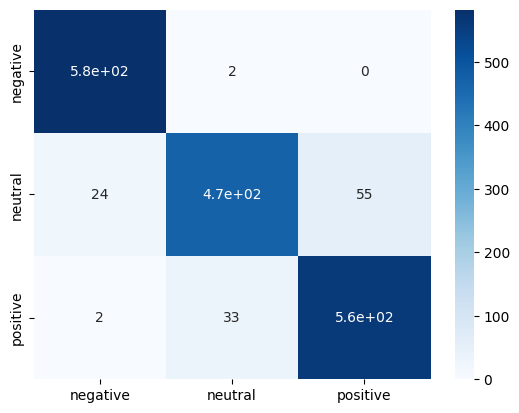

In [25]:
predictions,labels,_ = trainer.predict(eval_data)
prediction = np.argmax(predictions,axis=1)

print(classification_report(labels,prediction))

cm = confusion_matrix(labels,prediction)
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
# plt.show()

In [32]:
from transformers import pipeline,AutoTokenizer,AutoModelForSequenceClassification

In [34]:
model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")

pipeline = pipeline("sentiment-analysis",
                    model=model,
                    tokenizer = tokenizer)

text = "the company growth loog good"
cleaned = pre_processing(text)
result =pipeline(cleaned)
print(result)

Device set to use cuda:0


[{'label': 'Positive', 'score': 0.9999998807907104}]


In [35]:
trainer.save_model("/content/drive/MyDrive/finBERT/model")
tokenizer.save_pretrained("/content/drive/MyDrive/FinBERT/tokenizer")
import pickle
with open ("/content/drive/MyDrive/FinBERT/labelEncoder","wb") as f:
  pickle.dump(le,f)